In [64]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Test case 1: American call options without dividends

## Setup

In [74]:
import numpy as np
import pandas as pd
import option
import utils

K = 1
T = 1
call = option.call(K, T)
r = 0.1
sigma = 0.2
delta = 0
S_max = 2
S_test = np.arange(0.8, S_max + 0.1, step=0.2)

In [68]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(call, si, r, sigma, 1000, delta=delta) for si in S_test])

S_bar 1.3393393393393394


(-0.025, 0.5)

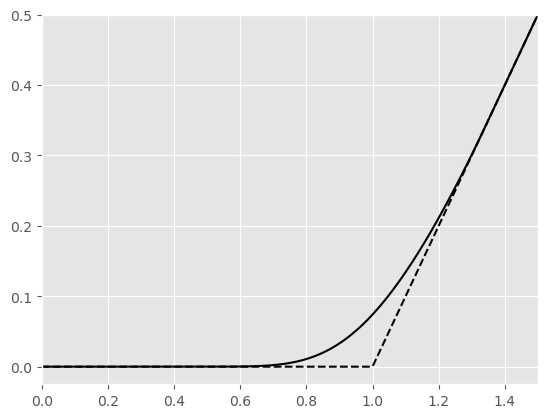

In [69]:
from scipy import interpolate

S_plot = np.linspace(0, 1.5, num=300)
V_plot = np.array([utils.calculate_amer_option(call, si, r, sigma, 500, delta=delta) for si in S_plot])

S_foo = np.linspace(K, 1.5, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmax(np.abs(V_foo(S_foo) - call.payoff(S_foo)) <= 0.00001)])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, call.payoff(S_plot), '--k')
plt.xlim([0, 1.5])
plt.ylim(top=0.5)

## Nielsen transformation

### Explicit

S_bar 2.1234495441742784
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.002621 -0.010625 -0.013524 -0.002015  -0.000001  0.010863
1.0  0.004706  0.013893  0.013002 -0.029306   0.000891  0.073976
1.2  0.014161  0.200000  0.200000  0.055699   0.025872  0.211129
1.4  0.037339  0.400000  0.400000  0.368943   0.159235  0.400000
1.6  0.060518  0.600000  0.600000  0.600000   0.428869  0.600000
1.8  0.131259  0.800000  0.800000  0.800000   0.733696  0.800000
2.0  0.245200  1.000000  1.000000  1.000000   0.991996  1.000000


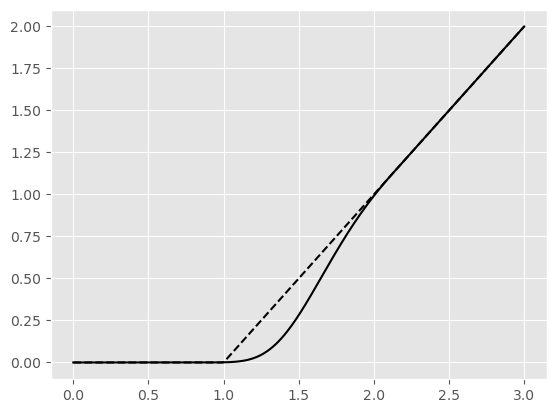

In [78]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = nielsen.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta)
    V_call = utils.interpolate_call_amer(call, S_bar, 5, S, V_call)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 3, num=300)  
        plt.plot(S_plot, V_call(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V_call(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [79]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.125        0.460305
0.0625       0.024482
0.03125      0.025175
0.015625     0.071670
0.0078125    0.137058
dtype: float64

### Implicit

S_bar 38241.90143753404
        0.125    0.0625   0.03125      0.015625  0.0078125      BOPM
0.8  0.000000  0.000000 -0.205959 -1.604973e+05   0.795922  0.010863
1.0  0.004449  0.005186  0.003192 -3.575623e+05   0.994903  0.073976
1.2  0.200000  0.200000  0.200000  1.721827e+05   1.193883  0.211129
1.4  0.400000  0.400000  0.400000 -3.568104e+05   1.392864  0.400000
1.6  0.600000  0.600000  0.600000  1.219693e+06   1.591844  0.600000
1.8  0.800000  0.800000  0.800000 -6.259446e+05   1.790825  0.800000
2.0  1.000000  1.000000  1.000000 -4.666436e+05   1.989806  1.000000


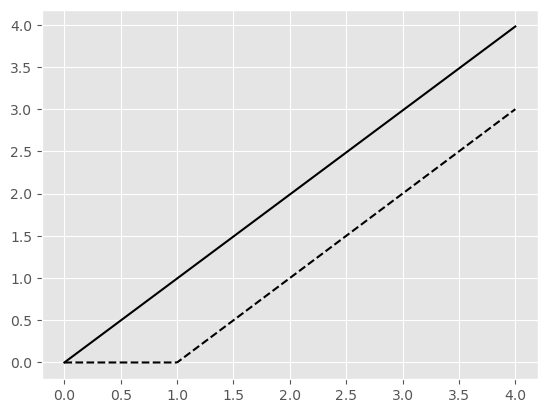

In [83]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    put = option.put(K, T)
    S, V_call, S_bar = nielsen.solve_implicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0.2, x_max=3)
    V_call = utils.interpolate_call_amer(call, S_bar, 5, S, V_call)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 4, num=300)  
        plt.plot(S_plot, V_call(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V_call(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

## Company transformation

### Explicit

S_bar 0.27948496518390537
         0.25    0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.000000  0.00000  0.000000  0.000000  0.000062   0.000000  0.010863
1.0  0.002145  0.00481  0.007385  0.002932 -0.069365   0.005883  0.073976
1.2  0.200000  0.20000  0.200000  0.200000  0.196188   0.200000  0.211129
1.4  0.400000  0.40000  0.400000  0.400000  0.400000   0.400000  0.400000
1.6  0.600000  0.60000  0.600000  0.600000  0.600000   0.600000  0.600000
1.8  0.800000  0.80000  0.800000  0.800000  0.800000   0.800000  0.800000
2.0  1.000000  1.00000  1.000000  1.000000  1.000000   1.000000  1.000000


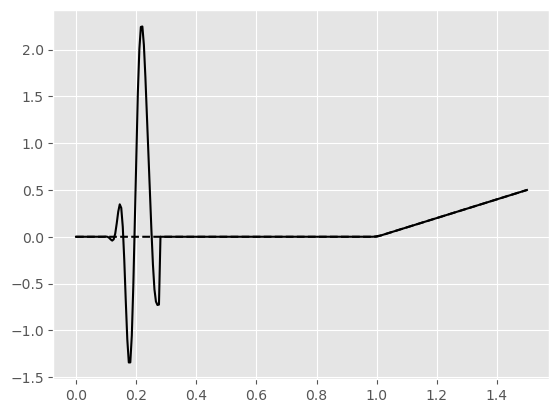

In [84]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen, company
from scipy import interpolate
import timeit

dx = [1/4, 1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = company.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_min=-3)
    S = np.append([0], S)
    V_call = np.append([0], V_call)
    V_call = utils.interpolate_call_amer(call, S_bar, 5, S, V_call)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V_call(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V_call(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [85]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.25         0.027779
0.125        0.026795
0.0625       0.025846
0.03125      0.027488
0.015625     0.054624
0.0078125    0.026399
dtype: float64

# Test case 2: American put options without dividends

## Setup

In [5]:
import numpy as np
import pandas as pd
import option
import utils

K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
S_max = 2
S_test = np.arange(0.8, S_max + 0.2, step=0.2)

In [6]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(put, si, r, sigma, 1000) for si in S_test])

S_bar 0.8633633633633634


(-0.05, 0.5)

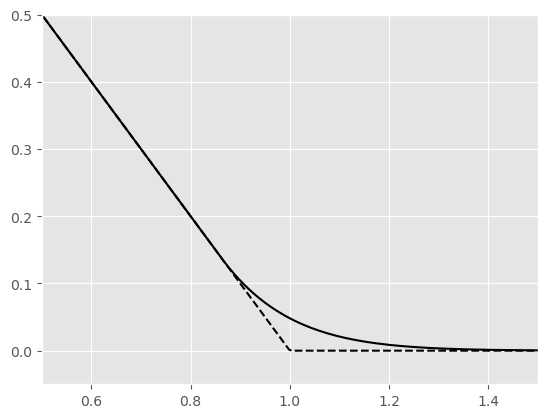

In [7]:
S_plot = np.linspace(0, 1.5, num=300)
V_plot = np.array([utils.calculate_amer_option(put, si, r, sigma, 500) for si in S_plot])

S_foo = np.linspace(0, 1.5, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmin(np.abs(V_foo(S_foo) - put.payoff(S_foo)) <= 0.00001)-1])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, put.payoff(S_plot), '--k')
plt.xlim([0.5, 1.5])
plt.ylim(top=0.5)

## Nielsen transformation

### Explicit

S_bar 0.8623220665208225
        0.125    0.0625   0.03125  0.015625  0.0078125     0.001      BOPM
0.8  0.200000  0.200000  0.200000  0.200000   0.200000  0.200000  0.200000
1.0  0.046048  0.047748  0.048176  0.048160   0.048155  0.048163  0.048167
1.2  0.008661  0.008638  0.008705  0.008674   0.008662  0.008657  0.008666
1.4  0.001467  0.001369  0.001313  0.001292   0.001286  0.001284  0.001285
1.6  0.000237  0.000196  0.000176  0.000170   0.000168  0.000167  0.000167
1.8  0.000038  0.000027  0.000022  0.000021   0.000020  0.000020  0.000020
2.0  0.000006  0.000004  0.000003  0.000002   0.000002  0.000002  0.000002


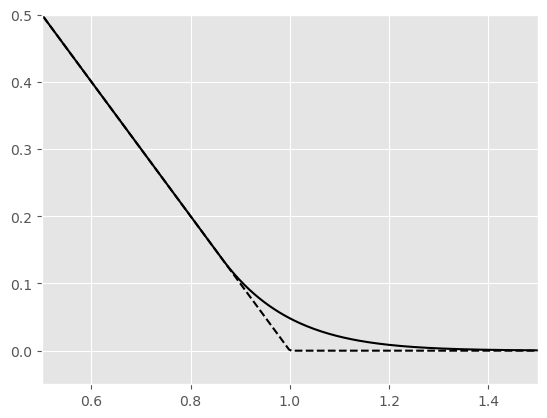

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128, 1/1000]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = nielsen.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=3)
    V_call = utils.interpolate_amer(put, S_bar, S, V_call)
    V_pred[i] = V_call(S_test)
    if i == len(dx)-1:
        plt.plot(np.linspace(0, 1.5, num=300), V_call(np.linspace(0, 1.5, num=300)), '-k')
        plt.plot(np.linspace(0, 1.5, num=300), put.payoff(np.linspace(0, 1.5, num=300)), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
        print("S_bar", S_bar)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values
# (V_bsf - table.loc[dx])

array([8.04559169e-04, 1.62149838e-04, 1.85638657e-05, 4.89075754e-06,
       5.07852638e-06, 3.96883363e-06])

### Implicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128, 1/1000]
dt = [1/8, 1/16, 1/32, 1/64, 1/128, 1/1000]

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = nielsen.solve_implicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=3)
    V_call = utils.interpolate_amer(put, S_bar, S, V_call)
    V_pred[i] = V_call(S_test)
    if i == len(dx)-1:
        plt.plot(np.linspace(0, 1.5, num=300), V_call(np.linspace(0, 1.5, num=300)), '-k')
        plt.plot(np.linspace(0, 1.5, num=300), put.payoff(np.linspace(0, 1.5, num=300)), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
        print("S_bar: ", S_bar)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values

## Company transformation

### Explicit

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import company
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = company.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0.01, x_max=3)
    V_call = utils.interpolate_put_amer(put, S_bar, S, V_call)
    V_pred[i] = V_call(S_test)
    if i == len(dx)-1:
        S_p = np.linspace(0, 1.5, num=300)
        print("S_bar", S_bar)
        plt.plot(S_p, V_call(S_p), '-k')
        plt.plot(S_p, put.payoff(S_p), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

NameError: name 'put' is not defined

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values

# Test case 3: American call options with dividends

## Setup

In [ ]:
import numpy as np
import pandas as pd
import option
import utils

K = 1
T = 1
call = option.call(K, T)
r = 0.1
sigma = 0.2
delta = 0.1
S_max = 2
S_test = np.arange(0.8, S_max + 0.1, step=0.2)

In [ ]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(call, si, r, sigma, 1000, delta=delta) for si in S_test])

In [ ]:
from scipy import interpolate

S_plot = np.linspace(0, 1.5, num=300)
V_plot = np.array([utils.calculate_amer_option(call, si, r, sigma, 500, delta=delta) for si in S_plot])

S_foo = np.linspace(K, 1.5, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmax(np.abs(V_foo(S_foo) - call.payoff(S_foo)) <= 0.00001)])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, call.payoff(S_plot), '--k')
plt.xlim([0, 1.5])
plt.ylim(top=0.5)

In [ ]:
S_foo = np.linspace(K, 1.5, num=1000)
print("S_bar", S_foo[np.argmax(np.abs(V_foo(S_foo) - call.payoff(S_foo)) <= 0.00001)])

S_bar 1.3393393393393394


## Nielsen transformation

### Explicit

S_bar 1.3512172955334787
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.017856  0.012721  0.011328  0.010972   0.010885  0.010863
1.0  0.077071  0.074867  0.074173  0.073987   0.073992  0.073976
1.2  0.208503  0.210335  0.210871  0.211101   0.211114  0.211129
1.4  0.400000  0.400000  0.400000  0.400000   0.400000  0.400000
1.6  0.600000  0.600000  0.600000  0.600000   0.600000  0.600000
1.8  0.800000  0.800000  0.800000  0.800000   0.800000  0.800000
2.0  1.000000  1.000000  1.000000  1.000000   1.000000  1.000000


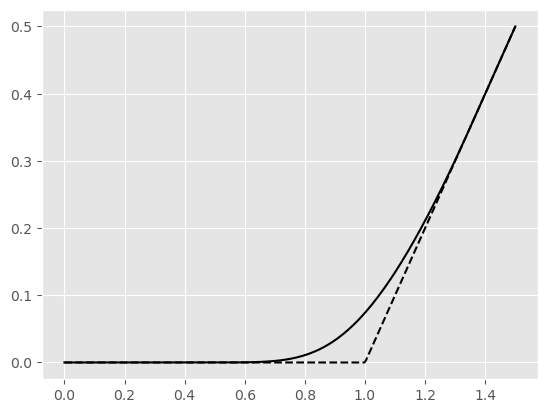

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = nielsen.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta)
    V_call = utils.interpolate_call_amer(call, S_bar, 5, S, V_call)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V_call(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V_call(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.125        0.003056
0.0625       0.000835
0.03125      0.000214
0.015625     0.000043
0.0078125    0.000011
dtype: float64

### Implicit

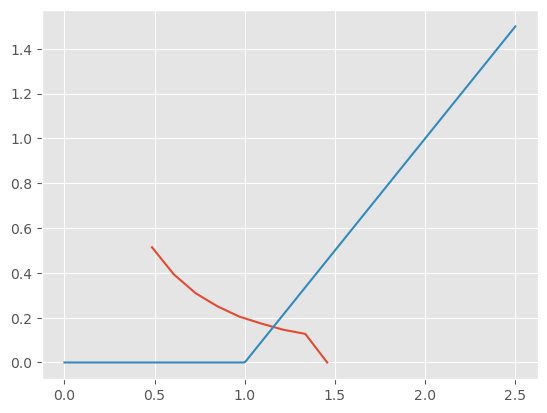

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/4]#[1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/4]#[1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    put = option.put(K, T)
    S, V_call, S_bar = nielsen.solve_implicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0.2, x_max=3)
    plt.plot(S, V_call)
    plt.plot(np.linspace(0, 2.5, num=300) , call.payoff(np.linspace(0, 2.5, num=300)))
#     V_put = utils.interpolate_call_amer(call, S_bar, 5, S, V_put)
#     if i == len(dx)-1:
#         S_plot = np.linspace(0, 2.5, num=300)  
#         plt.plot(S_plot, V_put(S_plot), '-k')
#         plt.plot(S_plot, call.payoff(S_plot), '--k')
#         print("S_bar", S_bar)
#     V_pred[i] = V_put(S_test)
# table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
# table.loc['BSF'] = V_bopm[:]
# print(table.T)

## Company transformation

## Explicit

S_bar 1.3459177383870804
         0.25     0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.014014  0.012919  0.011799  0.011138  0.010925   0.010876  0.010863
1.0  0.075013  0.076076  0.074601  0.074186  0.073976   0.073985  0.073976
1.2  0.222676  0.211265  0.211316  0.211228  0.211145   0.211126  0.211129
1.4  0.400000  0.400000  0.400000  0.400000  0.400000   0.400000  0.400000
1.6  0.600000  0.600000  0.600000  0.600000  0.600000   0.600000  0.600000
1.8  0.800000  0.800000  0.800000  0.800000  0.800000   0.800000  0.800000
2.0  1.000000  1.000000  1.000000  1.000000  1.000000   1.000000  1.000000


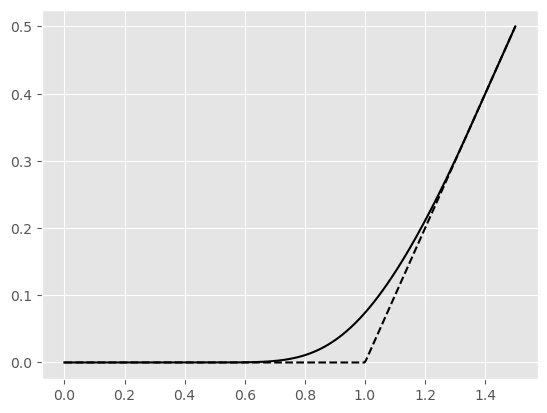

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen, company
from scipy import interpolate
import timeit

dx = [1/4, 1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = company.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_min=-3)
    S = np.append([0], S)
    V_call = np.append([0], V_call)
    V_call = utils.interpolate_call_amer(call, S_bar, 5, S, V_call)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V_call(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V_call(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.25         0.004541
0.125        0.001112
0.0625       0.000431
0.03125      0.000136
0.015625     0.000024
0.0078125    0.000006
dtype: float64

# TEST CASE 1: American out options without dividends

In [ ]:
import numpy as np
import pandas as pd
import option
import utils

K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
S_max = 2
dx = 0.2
S_test = np.arange(0.83, S_max + dx, step=dx)


## Front Fixing Method

### Nielsen transformation

#### Explicit

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = nielsen.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=3)
    exercise_region = np.linspace(0, S_bar, num=200, endpoint=False)
    V_inter = interpolate.interp1d(np.concatenate([exercise_region, S]), np.concatenate([put.payoff(exercise_region), V]))
    V_pred[i] = V_inter(S_test)

table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bsf.values
print(table.T)

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values


#### Implicit

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt =  [1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = nielsen.solve_implicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=3, tolerance=1e-24, maxiter=1000)
    print(S_bar)
    exercise_region = np.linspace(0, S_bar, num=200, endpoint=False)
    V_inter = interpolate.interp1d(np.concatenate([exercise_region, S]), np.concatenate([put.payoff(exercise_region), V]))
    V_pred[i] = V_inter(S_test)

table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_true.values 
print(table.T)

In [ ]:
(V_true.values - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values


### Company Transformation

#### Explicit

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import company
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt =  0.5 * np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = company.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=5)
    exercise_region = np.linspace(0, S_bar, num=200, endpoint=False)
    V_inter = interpolate.interp1d(np.concatenate([exercise_region, S]), np.concatenate([put.payoff(exercise_region), V]))
    V_pred[i] = V_inter(S_test)

table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_true.values 
print(table.T)

In [ ]:
(V_true.values - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values


#### Implicit

## Plots

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

S_test = np.linspace(0, S_max, num=100)
V_true = pd.Series([ utils.calculate_amer_option(put, Si,r=r,sigma=sigma, M=999, delta=0) for Si in S_test ], index=S_test)

In [ ]:
from scipy import interpolate
f_true = interpolate.interp1d(S_test, V_true)
S_fine = np.linspace(0, 1, num=10000)
S_bar_true = S_fine[np.argmin(np.abs(f_true(S_fine) - put.payoff(S_fine)) <= 0.000000001) - 1]

In [ ]:
S, V, S_bar = nielsen.solve_explicitly(put, 
    r=r,
    sigma=sigma, 
    dx=1e-3, 
    dt=.5e-6, 
    delta=0, 
    x_max=3
)
exercise_region = np.linspace(0, S_bar, num=200, endpoint=False)
f_pred = interpolate.interp1d(np.concatenate([exercise_region, S]), np.concatenate([put.payoff(exercise_region), V]))

plt.plot(S_test, f_pred(S_test), '-k')
plt.plot(S_test, put.payoff(S_test), '--k')
plt.xlim([.5, 1.5])
plt.ylim(top=0.5)
S_bar

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import company
from scipy import interpolate
import timeit

S, V, S_bar = nielsen.solve_implicitly(put, 
    r=r,
    sigma=sigma, 
    dx=1e-3, 
    dt=1e-3, 
    delta=0, 
    x_max=3
)
exercise_region = np.linspace(0, S_bar, num=200, endpoint=False)
f_pred = interpolate.interp1d(np.concatenate([exercise_region, S]), np.concatenate([put.payoff(exercise_region), V]))

plt.plot(S_test, f_pred(S_test), '-k')
plt.plot(S_test, put.payoff(S_test), '--k')
plt.xlim([0.5, 1.5])
plt.ylim(top=0.5)
S_bar

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import company
from scipy import interpolate
import timeit


S, V, S_bar = company.solve_explicitly(put, 
    r=r,
    sigma=sigma, 
    dx=1e-3, 
    dt=.5e-6, 
    delta=0, 
    x_max=3
)
exercise_region = np.linspace(0, S_bar, num=200, endpoint=False)
f_pred = interpolate.interp1d(np.concatenate([exercise_region, S]), np.concatenate([put.payoff(exercise_region), V]))

plt.plot(S_test, f_pred(S_test), '-k')
plt.plot(np.linspace(0, 1.5, num=300), put.payoff(np.linspace(0, 1.5, num=300)), '--k')
plt.xlim([0.5, 1.5])
plt.ylim(top=0.5)
S_bar

## Linear complementary problem

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = (1/8) * np.array(dx[:])

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V = lcp.solve(put, 
        r=r,
        sigma=sigma, 
        dx=dx[i], 
        dt=dt[i], 
        delta=0, 
        x_min=-3,
        x_max=3,
        theta=0.5
    )
    V_inter = interpolate.interp1d(S, V)
    V_pred[i] = V_inter(S_test)

table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_true.values
print(table.T)

In [ ]:
(V_true.values - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp

plt.style.use('ggplot')

S, V = lcp.solve(put, 
    r=r,
    sigma=sigma, 
    dx=1/128, 
    dt=1/1024, 
    delta=0, 
    x_min=-3,
    x_max=3,
    theta=0.5
)

f_pred = interpolate.interp1d(S, V)
plt.plot(np.linspace(0, 1.5, num=300), f_pred(np.linspace(0, 1.5, num=300)), '-k')
plt.plot(np.linspace(0, 1.5, num=300), put.payoff(np.linspace(0, 1.5, num=300)), '--k')
plt.xlim([0.5, 1.5])
plt.ylim(top=0.5)

In [ ]:
foo = np.linspace(0, 1.5, num=10000)
foo[np.argmin(f_pred(foo) - put.payoff(foo) < 0.000001)-1]

In [ ]:
import numpy as np
import pandas as pd
import option
import utils
from frontfixing import company
import matplotlib.pyplot as plt

K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
S_max = 2
dx = 1/8
company.solve_explicitly(put, r, sigma, dx, 0.5*dx**2)
plt.xlim([0.8,1.5])
plt.ylim([0,2])